In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

import joblib

from functions import advanced_hist, basic_hist, basic_bar, run_ttest, print_crosstab, test_category

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, precision_score, recall_score, roc_curve, auc, roc_auc_score, accuracy_score
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

**Context:** 
- We are provided with a dataset that can help us predict the probability of a patient getting a stroke based on the input parameters such as gender, age, various diseases and smoking status.

**Goals:** 
- Comparing different binary classifiers, come up with a usable machine learning model that can predict the probability of a given patient having a stroke. 
- Given the context, put extra emphasis on maximizing recall.

**Dataset:**
- 5110 patients
- 12 features

# 1 Data preprocessing

## 1.1 Dataset overview

_We take a peek into the structure of the dataset._

In [153]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


_We list all the features available_

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


_Immidiately we notice that there are quiet a few missing values in the `bmi` column. We will deal with this in a bit - first lets look for any other abnormalities in the data._

## 1.2 Outlier detection

### 1.2.1 Numerical variables

_We plot the distributions of numerical variables._

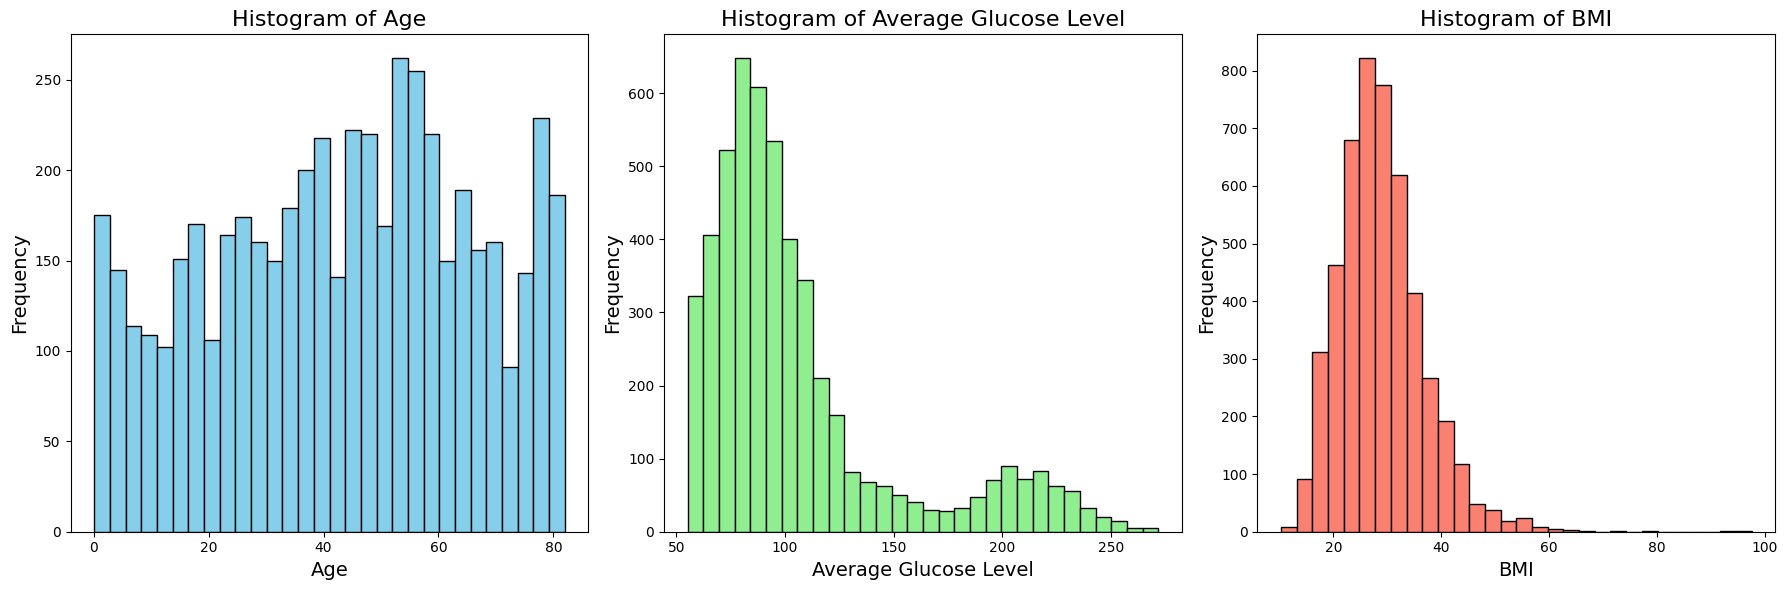

In [155]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

basic_hist(axes[0], df['age'], 'Age', 'skyblue')
basic_hist(axes[1], df['avg_glucose_level'], 'Average Glucose Level', 'lightgreen')
basic_hist(axes[2], df['bmi'], 'BMI', 'salmon')

plt.tight_layout()
plt.show()

_We take note of the heavy right tails of `Average Glucose Level` and `BMI` distributions.  While one could consider dropping some more extreme values of BMI, I don't think we should as they add valuable information. We will scale the data logarithmically later._

_We can see that age takes values between 0 and 82._

_Interestingly, after printing all unique age values, it turns out that for babies under the age of 2, age was provided with a precision of months, whereas for people older than 2, with a precision of years. This is something to keep in mind as well._

In [156]:
np.set_printoptions(precision=2, suppress=True)
unique_age = np.sort(df['age'].unique())
unique_age

array([ 0.08,  0.16,  0.24,  0.32,  0.4 ,  0.48,  0.56,  0.64,  0.72,
        0.8 ,  0.88,  1.  ,  1.08,  1.16,  1.24,  1.32,  1.4 ,  1.48,
        1.56,  1.64,  1.72,  1.8 ,  1.88,  2.  ,  3.  ,  4.  ,  5.  ,
        6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  , 13.  , 14.  ,
       15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  ,
       24.  , 25.  , 26.  , 27.  , 28.  , 29.  , 30.  , 31.  , 32.  ,
       33.  , 34.  , 35.  , 36.  , 37.  , 38.  , 39.  , 40.  , 41.  ,
       42.  , 43.  , 44.  , 45.  , 46.  , 47.  , 48.  , 49.  , 50.  ,
       51.  , 52.  , 53.  , 54.  , 55.  , 56.  , 57.  , 58.  , 59.  ,
       60.  , 61.  , 62.  , 63.  , 64.  , 65.  , 66.  , 67.  , 68.  ,
       69.  , 70.  , 71.  , 72.  , 73.  , 74.  , 75.  , 76.  , 77.  ,
       78.  , 79.  , 80.  , 81.  , 82.  ])

### 1.2.2 Categorical variables

_We simply plot bar plots of all the categories, including the target, `stroke` variable._

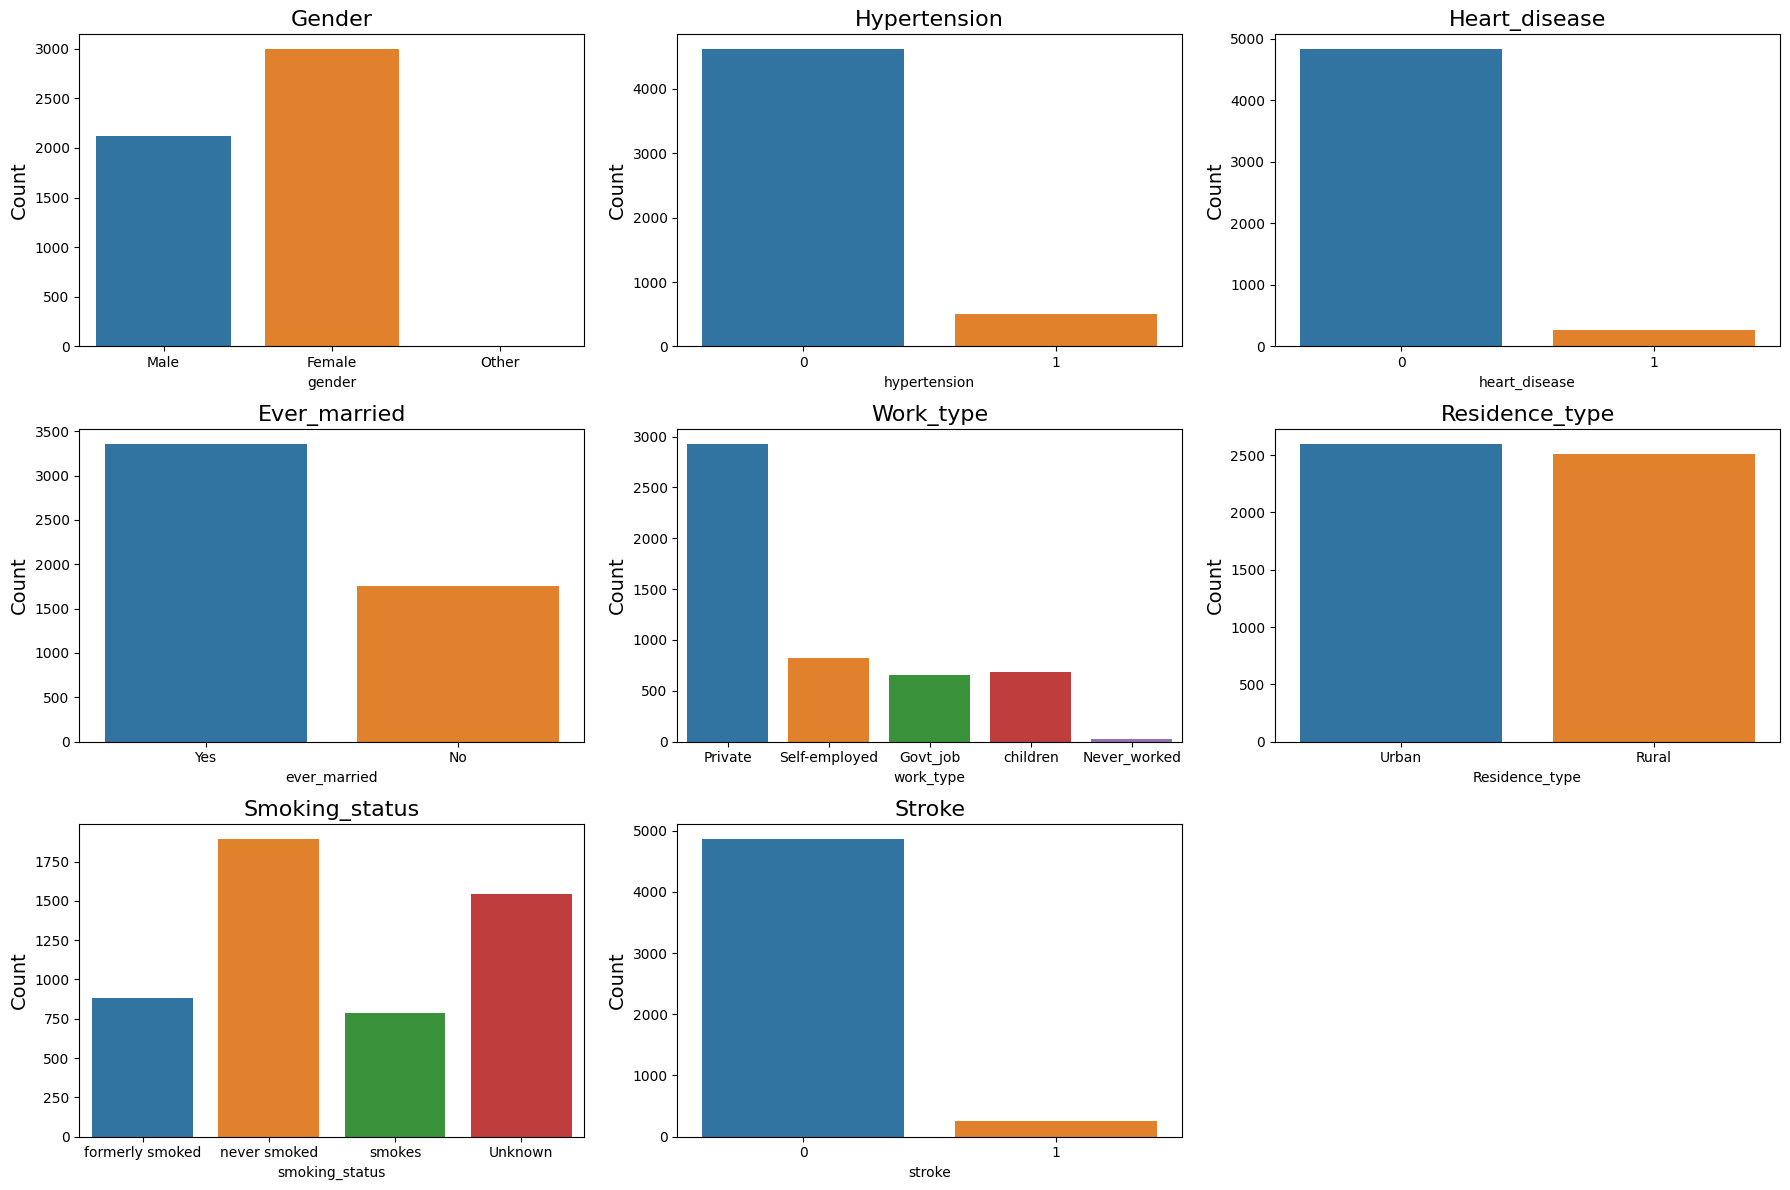

In [ ]:
categorical_variables = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']


fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, variable in enumerate(categorical_variables):
    row = i // 3
    col = i % 3
    basic_bar(axes[row,col], df[variable], variable.capitalize())

fig.delaxes(axes[2, 2])
plt.tight_layout()
plt.show()

_There are a couple of things to notice here._ 

- _First, we can see that some of our features are pretty imbalanced, including `stroke` which is our target variable. This makes using metrics such as precision difficult and is something we definitely need to keep in mind._
- _Some categories are really scarce, especially the 'Other' category of the `gender` variable - we can't even see the its bar. We will manually check these observations below._

In [158]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


_It turns out that there is just a single such observation. We can't make reliable predictions based on a single datapoint, so we will simply drop it._ 

In [159]:
df.drop(3116, inplace=True)

_Other category that raises some suspicion is the 'Never_worked' category of the `work_type` variable - let's examine these observations more closely._

In [160]:
df[df['work_type']=='Never_worked']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0
1462,41870,Male,17.0,0,0,No,Never_worked,Rural,61.01,32.5,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
1922,51935,Male,16.0,0,0,No,Never_worked,Urban,59.99,28.2,never smoked,0
2346,61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
2721,23508,Female,17.0,0,0,No,Never_worked,Rural,88.57,31.1,never smoked,0


_As we can see, all of the people labeled as 'Never_worked' are actually really young, some of them as young as 13 and 14. It thus seems, that most of them are actually mislabeled 'children' observations._

_I believe it makes much more sense to assign 'children' to all the people that are 18 or under and never worked, as they were probably still attending school when the data was being collected._

In [161]:
df.loc[(df['work_type']=='Never_worked') & (df['age'] <= 18), 'work_type'] = 'children'

In [162]:
df[df['work_type']=='Never_worked']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0


_This leaves us with just two outlying obesrvations in the 'Never_worked' category._
 
_These people are still very young, so I believe that putting them inside the 'children' category would still be reasonable. I will however simply drop them instead._

In [163]:
df.drop([603, 886], inplace=True)

_This concludes outlier detection._

## 1.3 Missing values and duplicates

### 1.3.1 Checking for duplicates

_First we will look for any duplicated rows._

In [164]:
df.duplicated().sum()

np.int64(0)

_As we can see, there are none. At this point we can drop the `id` column from the dataset, as it doesn't convey any meaningfull information and we definitely don't want our model to make predictions based on it. This leaves us with 11 features per row._

In [165]:
df.drop(columns=('id'), inplace=True)

### 1.3.2 Checking for missing values

_Next we check for any missing values._

In [166]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

_As we have already seen before, there are quite a few values missing from the `bmi` column. From here we can take one of the following approaches:_
- _Drop rows with the missing value altogether (this is reasonable as such rows constitute just around 4% of the dataset)_
- _Fill in the missing values somehow_

_We will go with the second approach and fill in the missing values. One could simply input a single constant, such as mean or median of the `bmi` column. We will use a slightly more sophisticated method and create a simple supplementary model to predict the missing `bmi` values._

> _Note:_
> _At this point we are running a risk of introducing some data leakage into the future test set. To avoid it we will do the train/test split right now, and train our supplementary model using only the training set. On top of that, we will make sure that this model won't utilize the `stroke` column - our overall target variable._

> _Note: Knowing how imbalanced our target variable is, we introduce stratification to our splits, to make sure that the proportion of stroke/no stroke is simillar between sets._

In [167]:
X_temp = df.drop(columns=['stroke']).copy()
y_temp = df['stroke'].copy()

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2,random_state=42, stratify=y_temp)

_We now set the test data aside and create a simple linear regression to fill in the missing values._

### 1.3.3 Predict missing values

>_Note: As we have seen before, the distribution of the `bmi` column, the variable we will try to predict right now, has a heavy right tail. This could influence the quality of our predictions. To tackle that, we will transform the `bmi` column logarithmically first, train our model to predict log values, and then transform the predicted values back with the exp function._

In [168]:
X_temp = X_train.dropna().copy()
target = np.log(X_temp['bmi']) 
numerical_features = ['age', 'avg_glucose_level']
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

bmi_regression = Pipeline(steps=[
    ('preprocessor', transformer),
    ('regressor', LinearRegression())
])

bmi_regression.fit(X_temp.drop(columns=('bmi')), target)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'avg_glucose_level']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'hypertension',
                                                   'heart_disease',
                                                   'ever_married', 'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('regressor', LinearRegression())])

_We have trained a linear regression model to predict the log `bmi` values. Now we can fill in all the missing values in the training and test set with the exponent of the prediction._

>_Note that we only used the values from X_train to train our regression. We also didn't look at the `stroke` column at all. We can safely use our model to fill the missing values in test data, without any data leakage._

In [169]:
def fill_missing_bmi(data, predicted_values):
    missing_mask = data['bmi'].isna()
    data_missing = data[missing_mask].drop(columns='bmi')
    preds = np.exp(predicted_values.predict(data_missing))
    data.loc[missing_mask, 'bmi'] = preds
    return data

X_train = fill_missing_bmi(X_train, bmi_regression)
X_test = fill_missing_bmi(X_test, bmi_regression)

_This concludes dealing with the missing values and all of the data preprocessing._

# 2 Exploratory Data Analysis

_Now that we have our dataset split and cleaned up, we will look into each of the features more closely, and try to analyse how different features interact with eachother._

## 2.1 Analysing the features

We will go through the dataset feature by feature and see how they interact with the `stroke` column - our target variable.

When checking for statistical importance, we will set the significance level to 0.05.

In [170]:
alpha = 0.05

### 2.1.0 Stroke

_This is our target variable, we have already seen that it is very imbalanced._

_How many people did at some point of their life experience a stroke?_

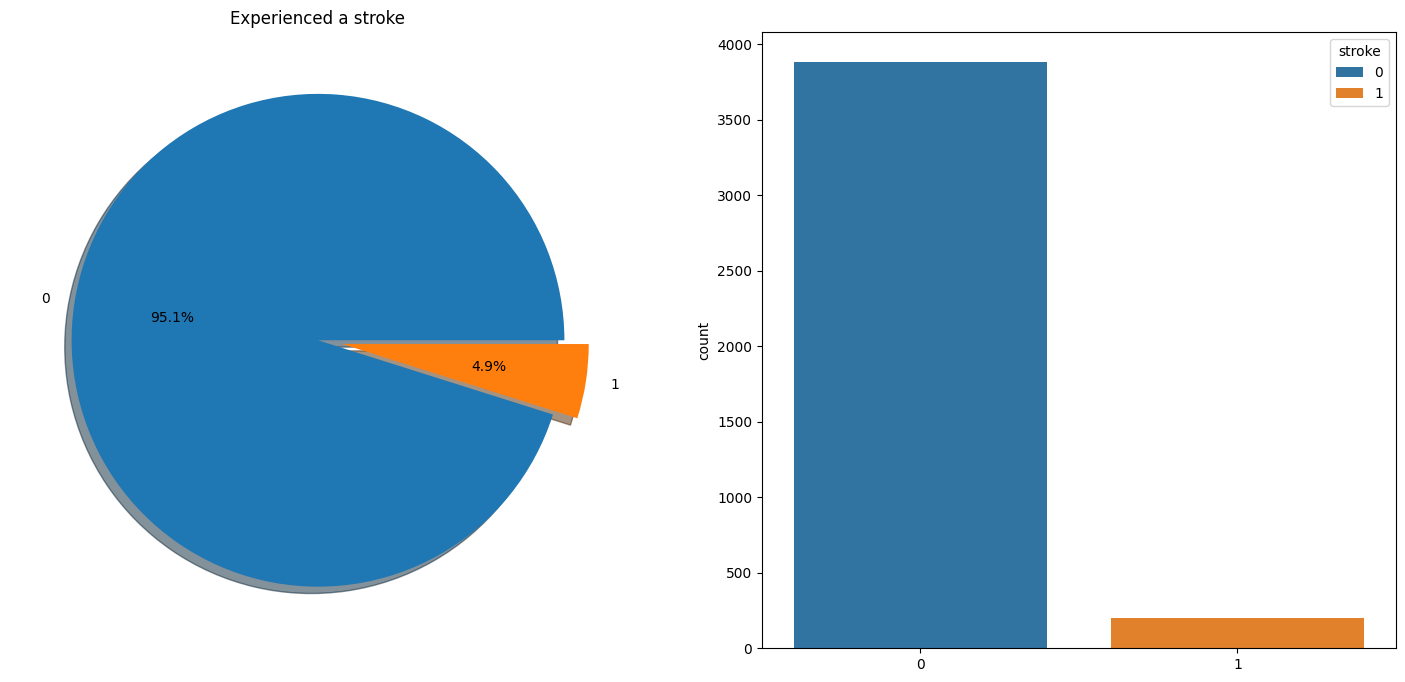

In [171]:
fig, ax = plt.subplots(1,2,figsize=(18,8))
y_train.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Experienced a stroke')
ax[0].set_ylabel('')
sns.countplot(x=y_train,ax=ax[1], hue=y_train)
ax[1].xaxis.label.set_visible(False)
plt.show()

### 2.1.1 Age

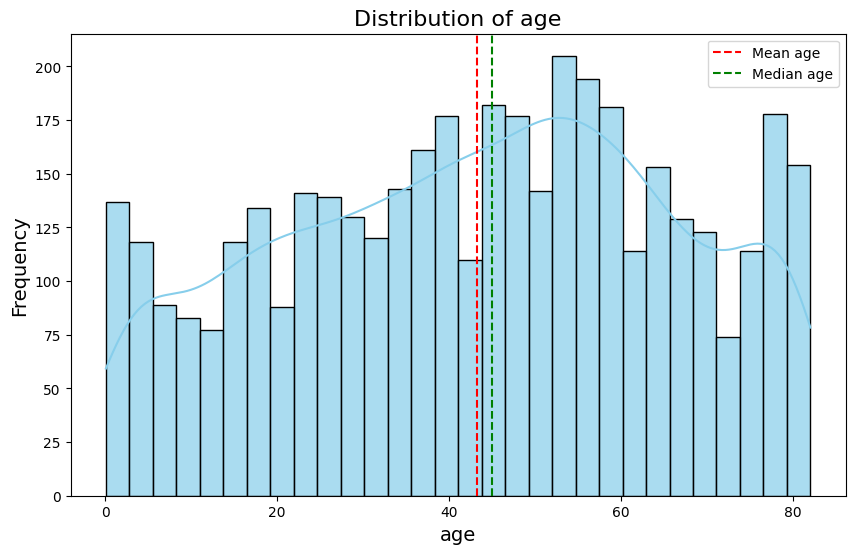

In [172]:
advanced_hist(X_train['age'], 'age', 30)

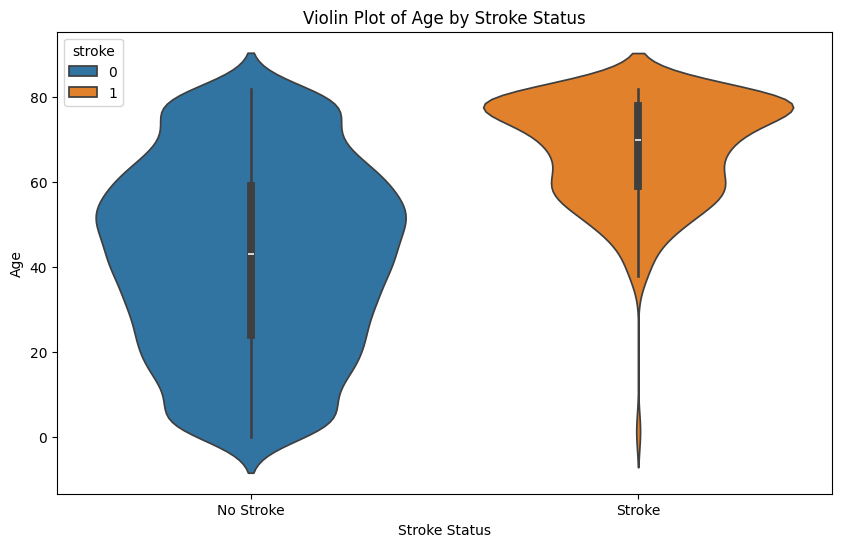

In [173]:
plt.figure(figsize=(10, 6))

sns.violinplot(x=y_train, y=X_train['age'], hue=y_train)

plt.xlabel('Stroke Status')
plt.ylabel('Age')
plt.title('Violin Plot of Age by Stroke Status')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

_We can clearly see that age is a very important factor in predicting whether a patient had a stroke. There are barely any strokes among people under 40, with the median falling around age 70._

_Let us confirm it with a t test._

In [174]:
age_no_stroke = X_train[y_train == 0]['age']
age_with_stroke = X_train[y_train == 1]['age']

run_ttest(age_no_stroke, age_with_stroke, 'Age', alpha)

Mean Age for No Stroke: 42.01
Mean Age for Stroke: 67.79
T-statistic: -27.63
P-value: 0.000000
We reject H0. The difference between groups is statistically significant.


___

### `--- Very important sidenote ---`

Examining the Age x Stroke violin plot lead me to have a bit of a revelation: 

``Our initial goal is impossible to achieve with the provided data``

It is impossible to predict the probability of a person having a stroke ``in the future``. This is simply because our dataset doesn't contain any information about the future of our patients. In other words, we can create a model that will predict if a given person `had a stroke in the past` but we can't say anything about the probability of him or her `having a stroke in the future`.

This raises a question - "Why would we even want to predict if a patient had a stroke in the past if we can simply ask them?"

I think there is actually quiet a bit of value in that - a doctor could provide our model with his patients data, the model would return a yes/no value or some probability (ex. 95% that the person did have one), and then if the patient actually didn't have a stroke this would raise the doctor's suspicion - "Wow, according to the data you are really lucky not to have had a stroke yet, we need to screen you as you fall into the risk group". However `this is just a heuristic` - our model provides the doctor with no information about the patients future.

We need to change our initial goal to:

- Comparing different binary classifiers, come up with a usable machine learning model that can predict the probability ~~of a given patient having a stroke~~ `of a given patient ever having a stroke in the past`. 

___

### 2.1.2 Average glucose level

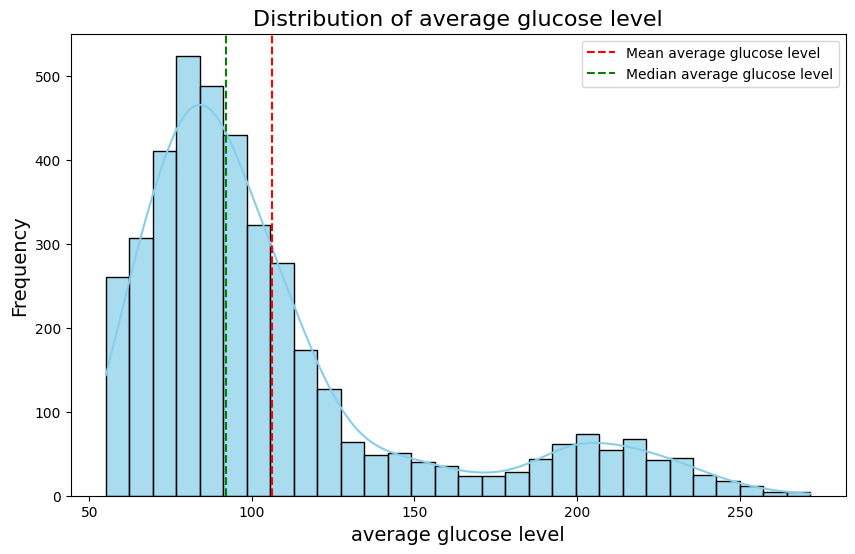

In [175]:
advanced_hist(X_train['avg_glucose_level'], 'average glucose level', 30)

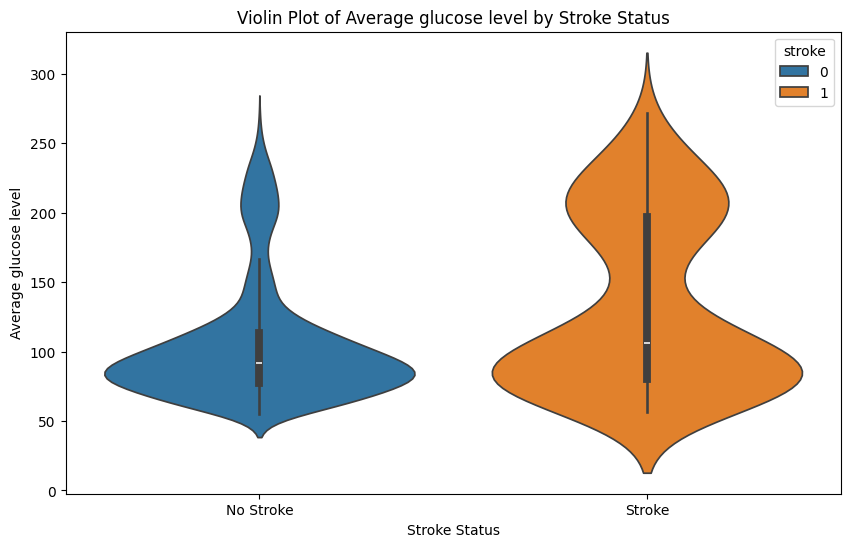

In [176]:
plt.figure(figsize=(10, 6))

sns.violinplot(x=y_train, y=X_train['avg_glucose_level'], hue=y_train)

plt.xlabel('Stroke Status')
plt.ylabel('Average glucose level')
plt.title('Violin Plot of Average glucose level by Stroke Status')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

In [177]:
gluc_no_stroke = X_train[y_train == 0]['avg_glucose_level']
gluc_with_stroke = X_train[y_train == 1]['avg_glucose_level']

run_ttest(gluc_no_stroke, gluc_with_stroke, 'Average Glucose Level', alpha)

Mean Average Glucose Level for No Stroke: 104.96
Mean Average Glucose Level for Stroke: 133.37
T-statistic: -6.33
P-value: 0.000000
We reject H0. The difference between groups is statistically significant.


_Although the difference is not as pronounced as before, the feature `avg_glucose_level`is clearly statistically significant as well. From the plot we can deduce, that while having a low average glucose level doesn't protect you from having a stroke, a high one increases your chances significantly._

### 2.1.3 BMI

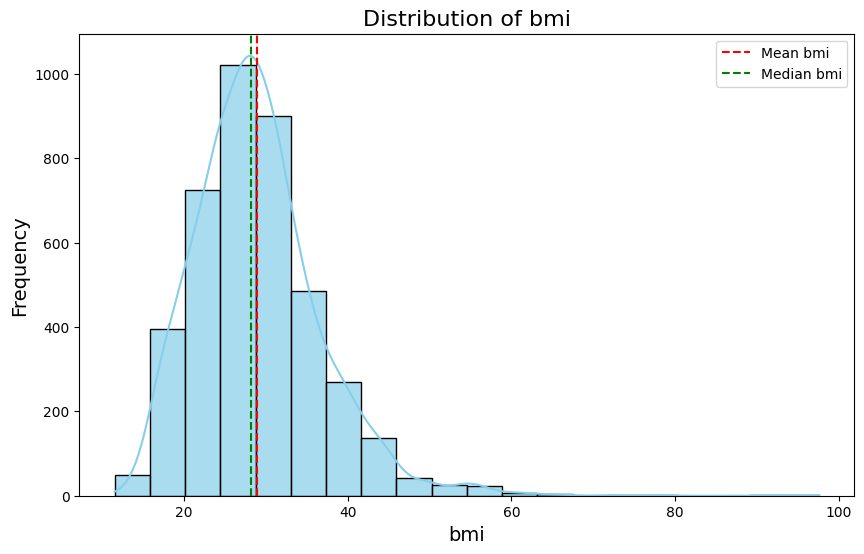

In [178]:
advanced_hist(X_train['bmi'], 'bmi', 20)

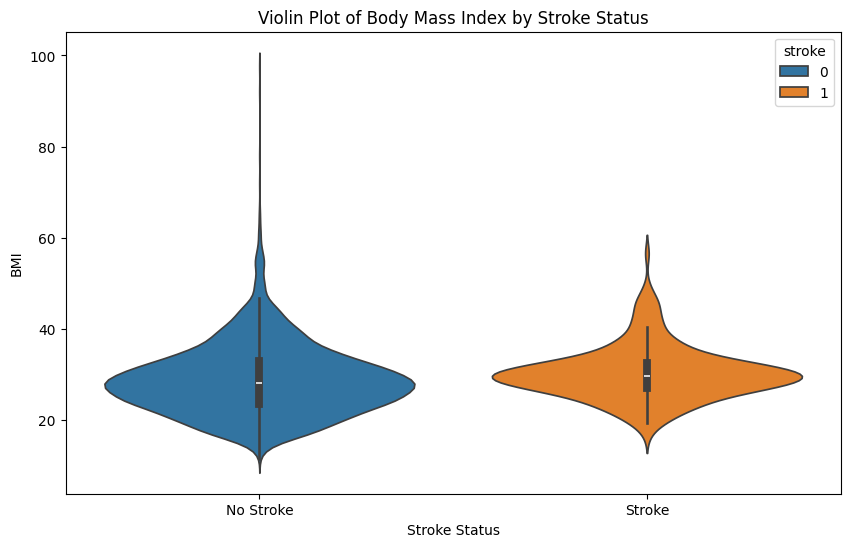

In [179]:
plt.figure(figsize=(10, 6))

sns.violinplot(x=y_train, y=X_train['bmi'], hue=y_train)

plt.xlabel('Stroke Status')
plt.ylabel('BMI')
plt.title('Violin Plot of Body Mass Index by Stroke Status')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

In [180]:
bmi_no_stroke = X_train[y_train == 0]['bmi']
bmi_with_stroke = X_train[y_train == 1]['bmi']

run_ttest(bmi_no_stroke, bmi_with_stroke, 'BMI', alpha)

Mean BMI for No Stroke: 28.87
Mean BMI for Stroke: 30.32
T-statistic: -3.34
P-value: 0.000967
We reject H0. The difference between groups is statistically significant.


### 2.1.4 Gender

In [181]:
print_crosstab(X_train['gender'], y_train)

stroke,0,1
gender,,
Female,95.5,4.5
Male,94.6,5.4
All,95.1,4.9


In [182]:
test_category(X_train['gender'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 1.677420740085533
P-value: 0.1952675282945893
We can't reject the null hypothesis - the feature is statistically insignificant.


### 2.1.5 Hypertension

In [183]:
print_crosstab(X_train['hypertension'], y_train)

stroke,0,1
hypertension,,
0,96.0,4.0
1,87.6,12.4
All,95.1,4.9


In [184]:
test_category(X_train['hypertension'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 55.464258167880686
P-value: 9.517386081700645e-14
We reject the null hypothesis, the feature is statistically significant.


### 2.1.6 Heart disease

In [185]:
print_crosstab(X_train['heart_disease'], y_train)

stroke,0,1
heart_disease,,
0,95.7,4.3
1,84.6,15.4
All,95.1,4.9


In [186]:
test_category(X_train['heart_disease'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 53.35113445147524
P-value: 2.78950090838078e-13
We reject the null hypothesis, the feature is statistically significant.


### 2.1.7 Ever married

In [187]:
print_crosstab(X_train['ever_married'], y_train)

stroke,0,1
ever_married,,
No,98.4,1.6
Yes,93.5,6.5
All,95.1,4.9


In [188]:
test_category(X_train['ever_married'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 46.51347429320459
P-value: 9.099061182155871e-12
We reject the null hypothesis, the feature is statistically significant.


### 2.1.8 Work type

In [189]:
print_crosstab(X_train['work_type'], y_train)

stroke,0,1
work_type,,
Govt_job,94.6,5.4
Private,95.1,4.9
Self-employed,91.7,8.3
children,99.8,0.2
All,95.1,4.9


In [190]:
test_category(X_train['work_type'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 43.54713513848165
P-value: 1.8833444809587312e-09
We reject the null hypothesis, the feature is statistically significant.


### 2.1.9 Residence type

In [191]:
print_crosstab(X_train['Residence_type'], y_train)

stroke,0,1
Residence_type,,
Rural,95.5,4.5
Urban,94.8,5.2
All,95.1,4.9


In [192]:
test_category(X_train['Residence_type'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 1.0458444476362558
P-value: 0.3064660928530822
We can't reject the null hypothesis - the feature is statistically insignificant.


### 2.1.10 Smoking status

In [193]:
print_crosstab(X_train['smoking_status'], y_train)

stroke,0,1
smoking_status,,
Unknown,96.8,3.2
formerly smoked,92.2,7.8
never smoked,95.4,4.6
smokes,94.4,5.6
All,95.1,4.9


In [194]:
test_category(X_train['smoking_status'], y_train, alpha)

H0: Feature is statistically insignificant
H1: Feature is statistically significant



Chi2 Statistic: 21.20686387369486
P-value: 9.535886839242442e-05
We reject the null hypothesis, the feature is statistically significant.


### Summary

_Out of 10 available features, we concluded that 8 are statistically important. These were:_
- _Three numerical features_
1. `age`
2. `bmi`
3. `avg_glucose_level`
- _Five categorical features_
1. `hypertension`
2. `heart_disese`
3. `ever_married`
4. `work_type`
5. `smoking_status`

_Using a chi2 test we concluded that two categorical features were insignificant, namely:_
1. `gender`
2. `residency_type`

_The fact that marriage is relevant to predicting stroke probability seems pretty surprising. I think that this variable might be highly correlated with age - people that never married are probably much younger than those who did._

## 2.2 Mutual information

_We now have an idea which features are statistically important. We will now try to quantify this importance by calculating their mutual information with target variable._

In [195]:
categorical_features = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'smoking_status', 'gender', 'Residence_type']
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)


mi_scores = mutual_info_classif(X_train_encoded, y_train)

mi_df = pd.DataFrame({'Feature': X_train_encoded.columns, 'Mutual Information': mi_scores})
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

print(mi_df)

                           Feature  Mutual Information
0                              age            0.044425
2                              bmi            0.009127
5                 ever_married_Yes            0.008147
3                   hypertension_1            0.008045
4                  heart_disease_1            0.004948
6                work_type_Private            0.004464
8               work_type_children            0.003771
12                     gender_Male            0.003482
1                avg_glucose_level            0.003216
7          work_type_Self-employed            0.003004
9   smoking_status_formerly smoked            0.000000
10     smoking_status_never smoked            0.000000
11           smoking_status_smokes            0.000000
13            Residence_type_Urban            0.000000


_We can see that all mutual information values are really small. This is probably because our target variable is very imbalanced._

## 2.3 Correlation analysis

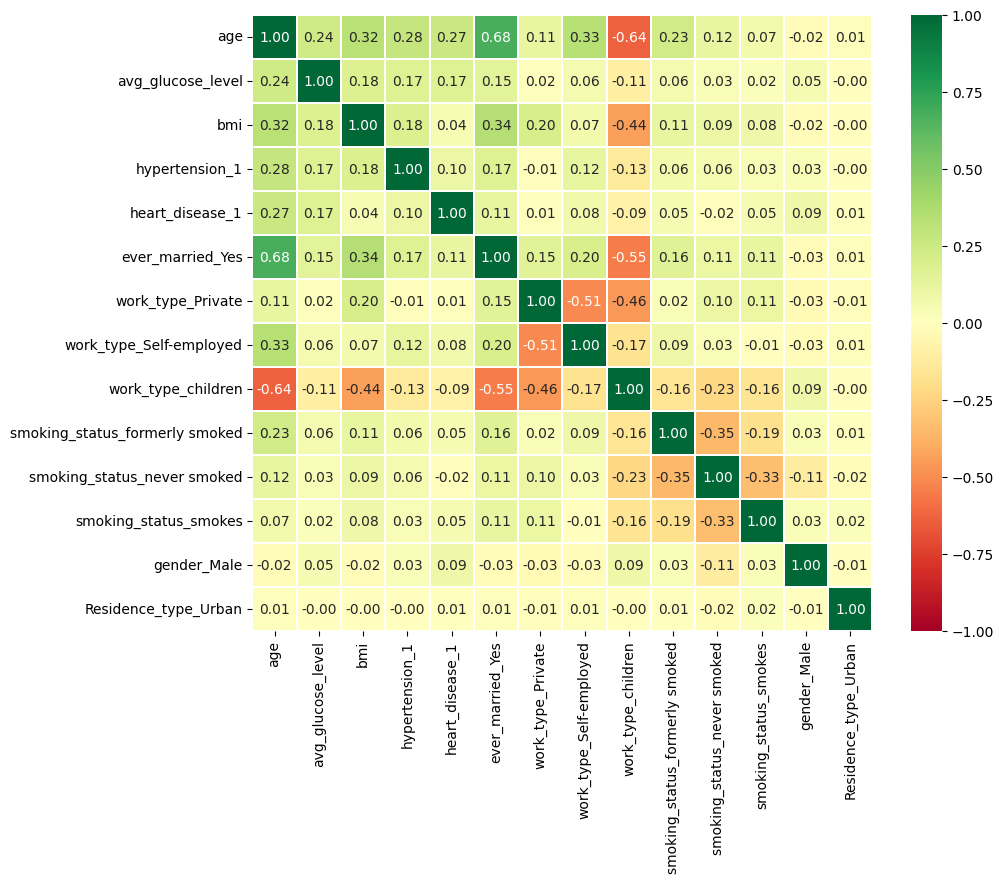

In [196]:
sns.heatmap(X_train_encoded.corr(), annot=True, cmap='RdYlGn', linewidths=0.2, 
            vmin=-1, vmax=1, fmt=".2f")

fig = plt.gcf()
fig.set_size_inches(10, 8)
plt.show()

_Correlation analysis alligns with our common sense, and doesn't really reveal anything unexpected:_

- _Married people are on average older than non married people_
- _Children are young (well, this was the critirion by which they were classified as children)_
- _Children don't really get married_

_Some slightly less obvious outcomes:_
- _Children have lower bmi compared to adults_
- _Married people seem to have higher bmi than non married people (although this is probably due to mutual correlation with age)_




# 3 Model training

## 3.1 Logistic regression

_The biggest challenge that our dataset poses is the imbalance of the target variable. We will use class weights to tackle it._

_We will start by creating a simple logistic regression model, which we will treat as our benchmark._

In [287]:
significant_numerical_features = ['age', 'avg_glucose_level', 'bmi']
significant_categorical_features = ['hypertension', 'heart_disease', 'ever_married', 'work_type', 'smoking_status']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, significant_numerical_features),
        ('cat', categorical_transformer, significant_categorical_features)
    ]
)

pipe1 = Pipeline(steps=[
    ('preprocessor', transformer),
    ('regressor', LogisticRegression(max_iter=1000))
])

lr = GridSearchCV(
    estimator=pipe1,
    param_grid={'regressor__class_weight': [{0: 1, 1: v} for v in range(1, 40)], 'regressor__C': [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 1, 10, 100, 1000]},
    scoring={'f1': make_scorer(f1_score), 'recall_score': make_scorer(recall_score), 'precision_score': make_scorer(precision_score, zero_division=0)},
    refit='f1',
    cv=10
    )

lr.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'smoking_status'])])),
                                       ('regressor',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'regresso...
                                                     {0: 1, 1: 20},
                                                     {0: 1, 1: 21},
                                                     {0: 1, 1: 22},
                                                     {0: 1, 1: 23},
                                                     {0: 1, 1: 24},
                                                     {0: 1, 1: 25},
                                                     {0: 1, 1: 26},
                                                     {0: 1, 1: 27},
                                                     {0: 1, 1: 28},
                                                     {0: 1, 1: 29},
                                                     {0: 1, 1: 30}, ...]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision_score': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

In [288]:
results = pd.DataFrame(lr.cv_results_)
logistic_regression_tuned = lr.best_estimator_

In [289]:
best_params = lr.best_params_
print("Best Hyperparameters:", best_params, ' Their f1:', lr.best_score_)

Best Hyperparameters: {'regressor__C': 1, 'regressor__class_weight': {0: 1, 1: 8}}  Their f1: 0.2744096768284464


_With GridSearch we conclude that the best logistic regeression uses regularization parameter C = 1 and sets the weight of the positive class to 8._

_We can examine how different weights influence our model performance._

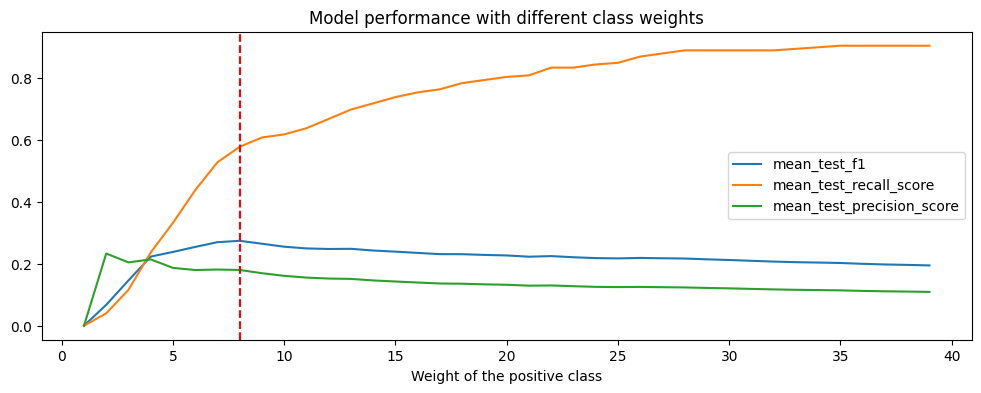

In [290]:
plt.figure(figsize=(12,4))
for score in ['mean_test_f1', 'mean_test_recall_score', 'mean_test_precision_score']:
    plt.plot([_[1] for _ in results[results['param_regressor__C']==1]['param_regressor__class_weight']],
             results[results['param_regressor__C']==1][score],
             label=score)
plt.legend()
plt.title('Model performance with different class weights')
plt.xlabel('Weight of the positive class')
plt.axvline(x=8, color='red', linestyle='--', label='Class Weight = 8');

_Having chosen the best model, we can plot its ROC curve._

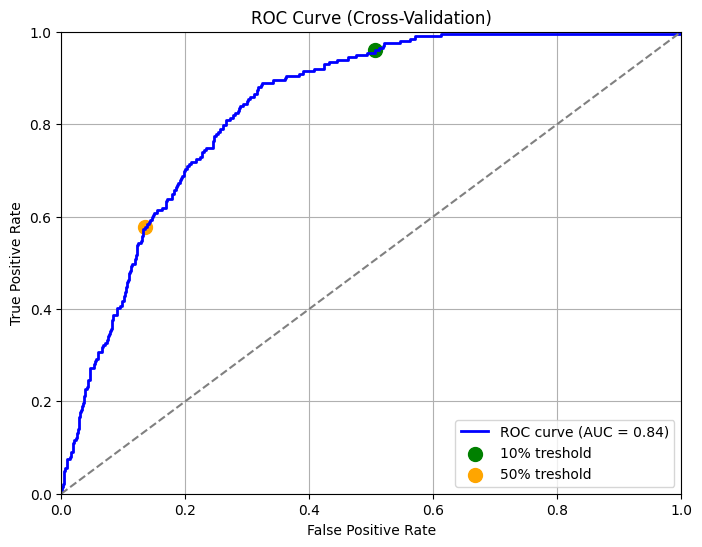

In [291]:
y_prob_cv = cross_val_predict(logistic_regression_tuned, X_train, y_train, cv=10, method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)

roc_auc = auc(fpr, tpr)

tr10 = 0.1
index_tr10 = np.argmin(np.abs(thresholds - tr10))
fpr_tr10 = fpr[index_tr10]
trp_tr10 = tpr[index_tr10]

tr50 = 0.5
index_tr50 = np.argmin(np.abs(thresholds - tr50))
fpr_tr50 = fpr[index_tr50]
trp_tr50 = tpr[index_tr50]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr_tr10, trp_tr10, color='green', s=100, label=f"10% treshold")
plt.scatter(fpr_tr50, trp_tr50, color='orange', s=100, label=f"50% treshold")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


>_By default, our model uses 50% probability as its decision treshold. However, knowing how our problem is formulated, one could think of making this treshold smaller. If we would move it to say 10%, our f1 metric performance would suffer, yet our recall would be almost perfect while still discarding a significant portion of healthy patients._

>_A model with this second treshold would also be much easier to interpret and use for the doctor. If a patient was classified as healthy, then the doctor would know that the patient is actually healthy with close to 100% probability. If the patient was classified as ill, then the doctor would know that the patient is still probably healthy, yet it is worth to put him into further screening._

In [ ]:
y_prob_cv = cross_val_predict(logistic_regression_tuned, X_train, y_train, cv=10, method="predict_proba")[:, 1]

thresholds = [0.5, 0.1]

for threshold in thresholds:
    y_pred_cv = (y_prob_cv >= threshold).astype(int)
    
    print(f"Confusion Matrix for Threshold {threshold * 100:.0f}%:")
    print(confusion_matrix(y_train, y_pred_cv))
    print(f"F1 Score for Threshold {threshold * 100:.0f}%: {f1_score(y_train, y_pred_cv):.4f}")
    print("\n")

Confusion Matrix for Threshold 50%:
[[3361  525]
 [  84  115]]
F1 Score for Threshold 50%: 0.2741


Confusion Matrix for Threshold 10%:
[[1918 1968]
 [   8  191]]
F1 Score for Threshold 10%: 0.1620




## 3.2 Random forest

_Next we train a random forest classifier._

In [296]:
pipe2 = Pipeline(steps=[
    ('preprocessor', transformer),
    ('regressor', RandomForestClassifier())
])

rf = GridSearchCV(
    estimator=pipe2,
    param_grid={'regressor__class_weight': [{0: 1, 1: v} for v in range(1, 40)]},
    scoring={'f1': make_scorer(f1_score), 'recall_score': make_scorer(recall_score), 'precision_score': make_scorer(precision_score, zero_division=0)},
    refit='f1',
    cv=10
    )

rf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'smoking_status'])])),
                                       ('regressor',
                                        RandomForestClassifier())]),
             param_grid={'regressor__class_...
                                                     {0: 1, 1: 20},
                                                     {0: 1, 1: 21},
                                                     {0: 1, 1: 22},
                                                     {0: 1, 1: 23},
                                                     {0: 1, 1: 24},
                                                     {0: 1, 1: 25},
                                                     {0: 1, 1: 26},
                                                     {0: 1, 1: 27},
                                                     {0: 1, 1: 28},
                                                     {0: 1, 1: 29},
                                                     {0: 1, 1: 30}, ...]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision_score': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

In [297]:
results = pd.DataFrame(rf.cv_results_)
random_forest1 = rf.best_estimator_

In [298]:
best_params = rf.best_params_
print("Best Hyperparameters:", best_params, ' Their f1:', rf.best_score_)

Best Hyperparameters: {'regressor__class_weight': {0: 1, 1: 7}}  Their f1: 0.02608695652173913


_Looking at the f1 score, it seems like our model is pretty terrible._

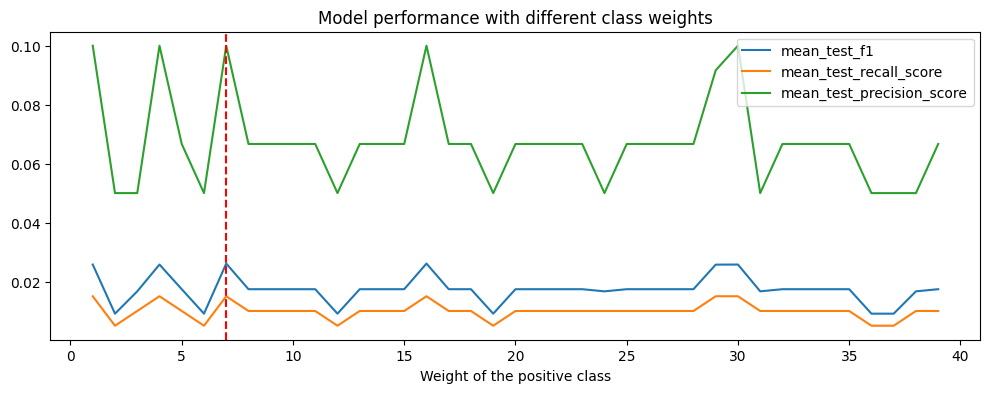

In [302]:
plt.figure(figsize=(12,4))
for score in ['mean_test_f1', 'mean_test_recall_score', 'mean_test_precision_score']:
    plt.plot([_[1] for _ in results['param_regressor__class_weight']],
             results[score],
             label=score)
plt.legend()
plt.title('Model performance with different class weights')
plt.xlabel('Weight of the positive class')
plt.axvline(x=7, color='red', linestyle='--', label='Class Weight = 7');

_It seems that setting the positive class weights, doesn't help our classifier at all._

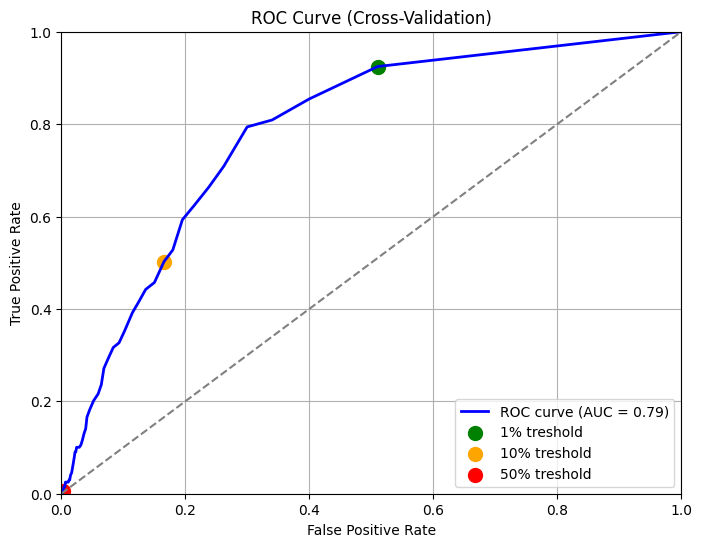

In [303]:
y_prob_cv = cross_val_predict(random_forest1, X_train, y_train, cv=10, method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)
roc_auc = auc(fpr, tpr)

tr1 = 0.01
index_tr1 = np.argmin(np.abs(thresholds - tr1))
fpr_tr1 = fpr[index_tr1]
trp_tr1 = tpr[index_tr1]

tr10 = 0.1
index_tr10 = np.argmin(np.abs(thresholds - tr10))
fpr_tr10 = fpr[index_tr10]
trp_tr10 = tpr[index_tr10]

tr50 = 0.5
index_tr50 = np.argmin(np.abs(thresholds - tr50))
fpr_tr50 = fpr[index_tr50]
trp_tr50 = tpr[index_tr50]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr_tr1, trp_tr1, color='green', s=100, label=f"1% treshold")
plt.scatter(fpr_tr10, trp_tr10, color='orange', s=100, label=f"10% treshold")
plt.scatter(fpr_tr50, trp_tr50, color='red', s=100, label=f"50% treshold")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


_Looking at the ROC curve we can see that our classification is actually not that bad if the threshold are set to be small enough._

_We will try to adress this problem by using minority class oversampling, on top of the class weights._

In [265]:
pipe2_1 = Pipeline(steps=[
    ('preprocessor', transformer),
    ('oversampler', SMOTE()),
    ('regressor', RandomForestClassifier(class_weight='balanced'))
])

rf_gs = GridSearchCV(
    estimator=pipe2_1,
    param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
},
    scoring={'f1': make_scorer(f1_score), 'recall_score': make_scorer(recall_score), 'precision_score': make_scorer(precision_score, zero_division=0)},
    refit='f1',
    cv=10
    )

rf_gs.fit(X_train, y_train)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'smoking_status'])])),
                                       ('oversampler', SMOTE()),
                                       ('regressor',
                                        RandomForestClassifier(class_weigh...
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [50, 100, 200]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, response_method='predict'),
                      'precision_score': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall_score': make_scorer(recall_score, response_method='predict')})

In [304]:
results_rf = pd.DataFrame(rf_gs.cv_results_)
random_forest_tuned = rf_gs.best_estimator_

In [305]:
best_params = rf_gs.best_params_
print("Best Hyperparameters:", best_params, ' Their f1:', rf_gs.best_score_)

Best Hyperparameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}  Their f1: 0.22931462594762525


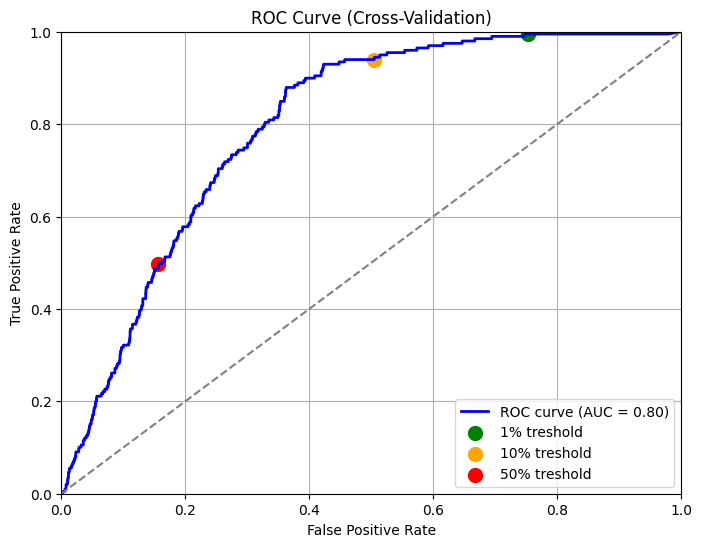

In [306]:
y_prob_cv = cross_val_predict(random_forest_tuned, X_train, y_train, cv=10, method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)
roc_auc = auc(fpr, tpr)

tr1 = 0.01
index_tr1 = np.argmin(np.abs(thresholds - tr1))
fpr_tr1 = fpr[index_tr1]
trp_tr1 = tpr[index_tr1]

tr10 = 0.1
index_tr10 = np.argmin(np.abs(thresholds - tr10))
fpr_tr10 = fpr[index_tr10]
trp_tr10 = tpr[index_tr10]

tr50 = 0.5
index_tr50 = np.argmin(np.abs(thresholds - tr50))
fpr_tr50 = fpr[index_tr50]
trp_tr50 = tpr[index_tr50]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr_tr1, trp_tr1, color='green', s=100, label=f"1% treshold")
plt.scatter(fpr_tr10, trp_tr10, color='orange', s=100, label=f"10% treshold")
plt.scatter(fpr_tr50, trp_tr50, color='red', s=100, label=f"50% treshold")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [ ]:
y_prob_cv = cross_val_predict(random_forest_tuned, X_train, y_train, cv=10, method="predict_proba")[:, 1]

thresholds = [0.5, 0.1, 0.01]

for threshold in thresholds:
    y_pred_cv = (y_prob_cv >= threshold).astype(int)
    
    print(f"Confusion Matrix for Threshold {threshold * 100:.0f}%:")
    print(confusion_matrix(y_train, y_pred_cv))
    print(f"F1 Score for Threshold {threshold * 100:.0f}%: {f1_score(y_train, y_pred_cv):.4f}")
    print("\n")

Confusion Matrix for Threshold 50%:
[[3271  615]
 [ 103   96]]
F1 Score for Threshold 50%: 0.2110


Confusion Matrix for Threshold 10%:
[[2003 1883]
 [  14  185]]
F1 Score for Threshold 10%: 0.1632


Confusion Matrix for Threshold 1%:
[[ 955 2931]
 [   1  198]]
F1 Score for Threshold 1%: 0.1190




## 3.3 XGBoost

In [277]:
pipe3 = Pipeline(steps=[
    ('preprocessor', transformer),
    ('oversampler', SMOTE()),
    ('regressor', xgb.XGBClassifier(scale_pos_weight=1))
])


xgb_gs = GridSearchCV(
    estimator=pipe3,
    param_grid={
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 6, 10],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0],
    'regressor__min_child_weight': [1, 3, 5],
},
    scoring={'f1': make_scorer(f1_score)},
    refit='f1',
    cv=10
)

xgb_gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['age',
                                                                          'avg_glucose_level',
                                                                          'bmi']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['hypertension',
                                                                          'heart_disease',
                                                                          'ever_married',
                                                                          'work_type',
                                                                          'smoking_status'])])),
                                       ('oversampler', SMOTE()),
                                       ('regressor',
                                        XGBClassifier(base_score=None,
                                                      boos...
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))]),
             param_grid={'regressor__colsample_bytree': [0.8, 1.0],
                         'regressor__learning_rate': [0.01, 0.1, 0.2],
                         'regressor__max_depth': [3, 6, 10],
                         'regressor__min_child_weight': [1, 3, 5],
                         'regressor__n_estimators': [50, 100, 200],
                         'regressor__subsample': [0.8, 1.0]},
             refit='f1',
             scoring={'f1': make_scorer(f1_score, response_method='predict')})

In [309]:
results_xgb = pd.DataFrame(xgb_gs.cv_results_)
xgb_tuned = xgb_gs.best_estimator_

In [310]:
best_params_xgb = xgb_gs.best_params_
print("Best Hyperparameters:", best_params_xgb, 'Their f1:', xgb_gs.best_score_)

Best Hyperparameters: {'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 10, 'regressor__min_child_weight': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 1.0} Their f1: 0.23978758217155746


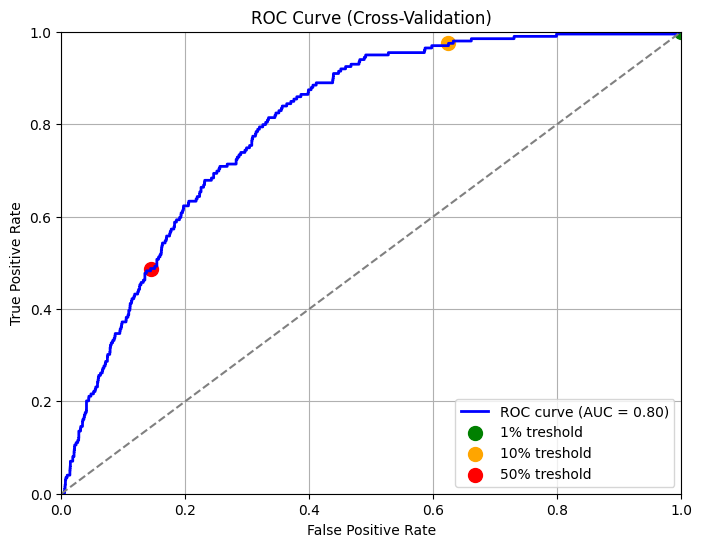

In [311]:
y_prob_cv = cross_val_predict(xgb_tuned, X_train, y_train, cv=10, method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_prob_cv)
roc_auc = auc(fpr, tpr)

tr1 = 0.01
index_tr1 = np.argmin(np.abs(thresholds - tr1))
fpr_tr1 = fpr[index_tr1]
trp_tr1 = tpr[index_tr1]

tr10 = 0.1
index_tr10 = np.argmin(np.abs(thresholds - tr10))
fpr_tr10 = fpr[index_tr10]
trp_tr10 = tpr[index_tr10]

tr50 = 0.5
index_tr50 = np.argmin(np.abs(thresholds - tr50))
fpr_tr50 = fpr[index_tr50]
trp_tr50 = tpr[index_tr50]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.scatter(fpr_tr1, trp_tr1, color='green', s=100, label=f"1% treshold")
plt.scatter(fpr_tr10, trp_tr10, color='orange', s=100, label=f"10% treshold")
plt.scatter(fpr_tr50, trp_tr50, color='red', s=100, label=f"50% treshold")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Cross-Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [317]:
y_prob_cv = cross_val_predict(xgb_tuned, X_train, y_train, cv=10, method="predict_proba")[:, 1]

for threshold in thresholds:
    y_pred_cv = (y_prob_cv >= threshold).astype(int)
    
    print(f"Confusion Matrix for Threshold {threshold * 100:.0f}%:")
    print(confusion_matrix(y_train, y_pred_cv))
    print(f"F1 Score for Threshold {threshold * 100:.0f}%: {f1_score(y_train, y_pred_cv):.4f}")
    print("\n")

Confusion Matrix for Threshold 50%:
[[3324  562]
 [ 105   94]]
F1 Score for Threshold 50%: 0.2199


Confusion Matrix for Threshold 10%:
[[1446 2440]
 [   6  193]]
F1 Score for Threshold 10%: 0.1363


Confusion Matrix for Threshold 1%:
[[   0 3886]
 [   0  199]]
F1 Score for Threshold 1%: 0.0929




# 4 Model testing

In [321]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}", "\n")

print("Logistic Regression Tuned:")
evaluate_model(logistic_regression_tuned, X_test, y_test)

print("Random Forest Tuned:")
evaluate_model(random_forest_tuned, X_test, y_test)

print("XGBoost Tuned:")
evaluate_model(xgb_tuned, X_test, y_test)

Logistic Regression Tuned:
Accuracy: 0.8474
Precision: 0.1919
Recall: 0.6600
F1 Score: 0.2973 

Random Forest Tuned:
Accuracy: 0.8180
Precision: 0.1383
Recall: 0.5200
F1 Score: 0.2185 

XGBoost Tuned:
Accuracy: 0.8307
Precision: 0.1564
Recall: 0.5600
F1 Score: 0.2445 



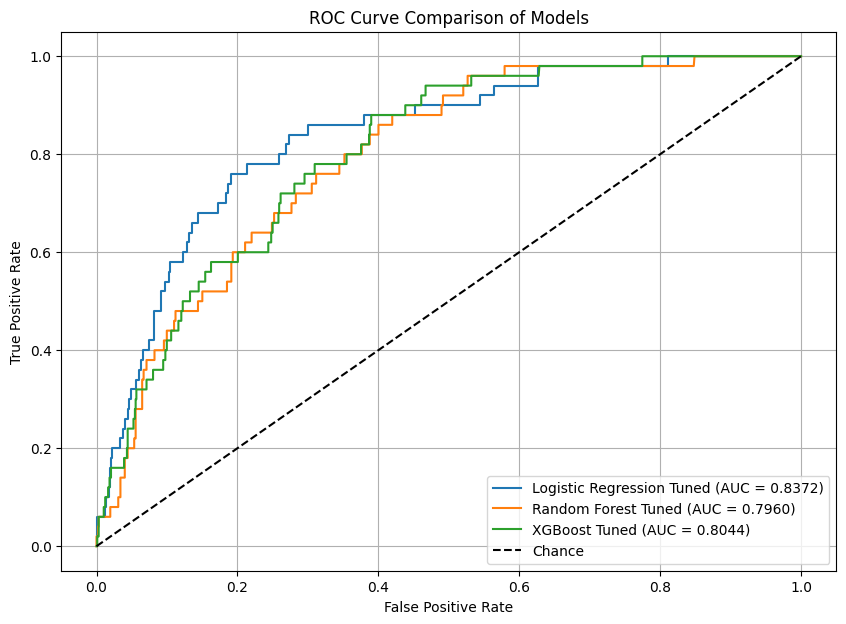

In [ ]:
plt.figure(figsize=(10, 7))

def plot_roc(model, X_test, y_test, label):
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.4f})")

plot_roc(logistic_regression_tuned, X_test, y_test, "Logistic Regression Tuned")
plot_roc(random_forest_tuned, X_test, y_test, "Random Forest Tuned")
plot_roc(xgb_tuned, X_test, y_test, "XGBoost Tuned")

plt.plot([0, 1], [0, 1], 'k--', label="Chance")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison of Models")
plt.legend(loc="lower right")
plt.grid()

plt.show()

# 5 Model deployment

_We save the model we picked as the best._

In [324]:
joblib.dump(logistic_regression_tuned, "logistic_regression_tuned.pkl")

['logistic_regression_tuned.pkl']

# 6 Summary